In [216]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from scipy.stats import poisson, ttest_ind

In [214]:
%reset -f

In [227]:
data  = pd.read_csv('/home/vfaybusovich/Auto ML dip 30.11.csv', encoding='windows-1251', sep=';')
stock = pd.read_csv('/home/vfaybusovich/Auto ML dip stock 30.11.csv', encoding='windows-1251', sep=';')

In [228]:
data.head()

,YYYYMM,Date,Category3,Category4,Brand,SupplierID,SellerID,RezonItemID,is_promo,stock_qty,GMV_wo_VAT,GMV_wo_VAT_Acc,Items_Acc
0,202504,2025-04-28,Масла автомобильные,Автохимия - Масло моторное,MOBIL,11014624780600,225649,1728344683,1,2,0.0000,0.0000,0.0
1,202505,2025-05-26,Масла автомобильные,Автохимия - Масло моторное,NGN,11217673747890,97825,207538280,0,5,625.8333,624.1667,1.0
2,202404,2024-04-24,Масла автомобильные,Автохимия - Масло моторное,Hyundai XTeer,11410646667980,351961,874018162,0,30,0.0000,0.0000,0.0
3,202405,2024-05-15,Масла автомобильные,Автохимия - Масло моторное,RUXX OIL,11507758250330,501803,1013631980,0,7,0.0000,0.0000,0.0
4,202402,2024-02-23,Масла автомобильные,Автохимия - Масло моторное,MOBIL,11715435444080,1234138,1392697387,0,300,0.0000,0.0000,0.0


In [229]:
# Переименовываем колонку
stock = stock.rename(columns = {'DATE': 'date'})

# Получаем уникальные товары
unique_items = data['RezonItemID'].unique()

# Создаем полный диапазон дат
date_range = pd.date_range(start = '2024-01-01', end = '2025-09-30', freq='D')

# Создаем MultiIndex со всеми комбинациями товар-дата
multi_index = pd.MultiIndex.from_product([unique_items, date_range], names = ['RezonItemID', 'date'])

# Создаем полный датафрейм-шаблон
complete_template = pd.DataFrame(index=multi_index).reset_index()

### Создали шаблон для датасета с датами и SKU, наполнили его данными

In [230]:
# Приводим даты к datetime в обоих датафреймах
complete_template['date'] = pd.to_datetime(complete_template['date'])
stock['date'] = pd.to_datetime(stock['date'])

# Переименовываем колонку
stock = stock.rename(columns={'DATE': 'date'})

# Теперь объединяем
merged_df = pd.merge(
    complete_template,
    stock[['RezonItemID', 'date', 'stock_qty']],
    on=['RezonItemID', 'date'],
    how='left'
)

# Заполняем пропуски нулями
merged_df['stock_qty'] = merged_df['stock_qty'].fillna(0)

# Находим первую дату с положительным стоком для каждого товара
first_stock_dates = merged_df[merged_df['stock_qty'] > 0].groupby('RezonItemID')['date'].min()

# Создаем Series с первой датой для каждого товара
first_dates_series = merged_df['RezonItemID'].map(first_stock_dates)

# Фильтруем: оставляем только строки, где дата >= первой даты с стоком
mask = (merged_df['date'] >= first_dates_series) | first_dates_series.isna()

# Применяем фильтр
filtered_df = merged_df[mask].copy()

### Создаём датасет с информацией о перерывах в наличии товара на стоке

In [231]:
def analyze_stock_breaks_fast(filtered_df):
    """
    Быстрый анализ перерывов между днями наличия стока
    """
    # 1. Фильтруем только дни, когда сток был > 0
    stock_days = filtered_df[filtered_df['stock_qty'] > 0].copy()
    
    # 2. Сортируем по товару и дате для корректного вычисления разниц
    stock_days = stock_days.sort_values(['RezonItemID', 'date'])
    
    # 3. Вычисляем разницу в днях между последовательными днями с стоком
    # для каждого товара отдельно
    stock_days['days_between_stock'] = stock_days.groupby('RezonItemID')['date'].diff().dt.days
    
    # 4. Убираем NaN значения (первые дни для каждого товара)
    breaks_with_nan = stock_days['days_between_stock'].dropna()
    
    # 5. Вычитаем 1 день, потому что нам нужен перерыв между днями,
    # а не разница в датах
    # Пример: даты 01-01 и 01-03 -> разница 2 дня, но перерыв 1 день (02-01)
    breaks_with_gaps = breaks_with_nan - 1
    
    # 6. Фильтруем только положительные перерывы (> 0 дней)
    # Исключаем последовательные дни (перерыв = 0)
    positive_breaks = breaks_with_gaps[breaks_with_gaps > 0]
    
    print(f"Найдено перерывов: {len(positive_breaks)}")
    
    return positive_breaks

breaks_series = analyze_stock_breaks_fast(filtered_df)

Найдено перерывов: 268649


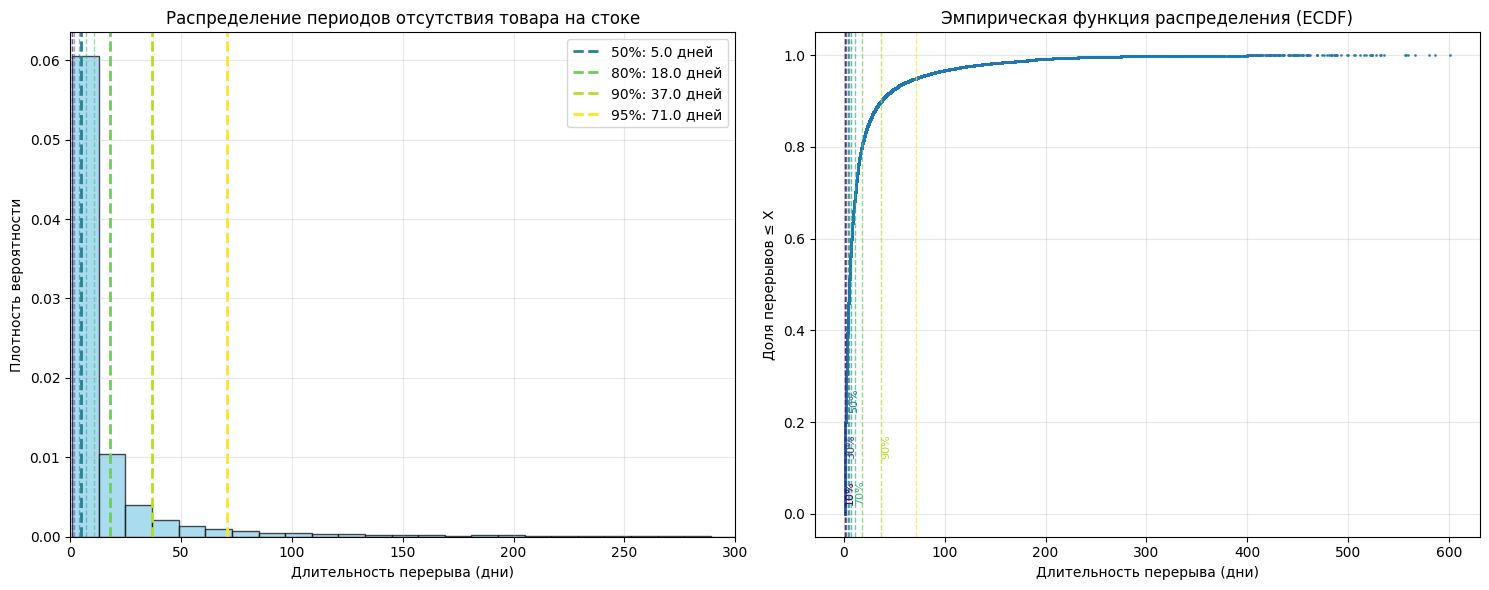

Детальная статистика перерывов:
Общее количество перерывов: 268649
Минимальный перерыв: 1.0 дней
Максимальный перерыв: 601.0 дней
Средний перерыв: 16.3 дней
Медиана перерывов: 5.0 дней

Перцентили:
  10%: 1.0 дней
  20%: 1.0 дней
  30%: 2.0 дней
  40%: 4.0 дней
  50%: 5.0 дней
  60%: 7.0 дней
  70%: 11.0 дней
  80%: 18.0 дней
  90%: 37.0 дней
  95%: 71.0 дней


In [232]:
def plot_breaks_distribution(breaks_series):
    """
    Визуализирует распределение перерывов между периодами стока
    """
    
    # Вычисляем перцентили
    percentiles = {
        '10%': breaks_series.quantile(0.10),
        '20%': breaks_series.quantile(0.20),
        '30%': breaks_series.quantile(0.30),
        '40%': breaks_series.quantile(0.40),
        '50%': breaks_series.quantile(0.50),
        '60%': breaks_series.quantile(0.60),
        '70%': breaks_series.quantile(0.70), 
        '80%': breaks_series.quantile(0.80),
        '90%': breaks_series.quantile(0.90),
        '95%': breaks_series.quantile(0.95)
    }
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Гистограмма с перцентилями
    n, bins, patches = ax1.hist(breaks_series, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    
    # Цвета для перцентилей
    colors = plt.cm.viridis(np.linspace(0, 1, len(percentiles)))
    
    # Отображаем только ключевые перцентили на легенде чтобы не перегружать
    key_percentiles = {'50%': '50%', '80%': '80%', '90%': '90%', '95%': '95%'}
    
    for i, (label, value) in enumerate(percentiles.items()):
        color = colors[i]
        if label in key_percentiles:
            ax1.axvline(value, color=color, linestyle='--', linewidth=2, 
                       label=f'{label}: {value:.1f} дней')
        else:
            ax1.axvline(value, color=color, linestyle='--', linewidth=1, alpha=0.5)
    
    ax1.set_xlabel('Длительность перерыва (дни)')
    ax1.set_ylabel('Плотность вероятности')
    ax1.set_title('Распределение периодов отсутствия товара на стоке')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 300)
    
    # 2. Эмпирическая функция распределения (ECDF)
    sorted_breaks = np.sort(breaks_series)
    y = np.arange(1, len(sorted_breaks) + 1) / len(sorted_breaks)
    
    ax2.plot(sorted_breaks, y, marker='.', linestyle='none', alpha=0.8, markersize=2)
    ax2.set_xlabel('Длительность перерыва (дни)')
    ax2.set_ylabel('Доля перерывов ≤ X')
    ax2.set_title('Эмпирическая функция распределения (ECDF)')
    ax2.grid(True, alpha=0.3)
    
    # Добавляем все перцентили на ECDF
    for i, (label, value) in enumerate(percentiles.items()):
        color = colors[i]
        ax2.axvline(value, color=color, linestyle='--', linewidth=1, alpha=0.7)
        if i % 2 == 0:
            ax2.text(value, 0.02 + (i * 0.05) % 0.3, f'{label}', 
                    rotation=90, va='bottom', color=color, fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Статистика
    print("Детальная статистика перерывов:")
    print(f"Общее количество перерывов: {len(breaks_series)}")
    print(f"Минимальный перерыв: {breaks_series.min():.1f} дней")
    print(f"Максимальный перерыв: {breaks_series.max():.1f} дней")
    print(f"Средний перерыв: {breaks_series.mean():.1f} дней")
    print(f"Медиана перерывов: {breaks_series.median():.1f} дней")
    print("\nПерцентили:")
    for label, value in percentiles.items():
        print(f"  {label}: {value:.1f} дней")
    
    return percentiles

# Запускаем визуализацию
percentiles = plot_breaks_distribution(breaks_series)

### Принятие решения о буферном периоде для восстановления спроса

Как можно увидеть, использование в качестве буферного периода промежутка в 11 дней позволит нам покрыть 70% всех периодов отсутствия товара на складе. Данный промежуток времени кажется наиболее оптимальным с точки зрения реальности восстановления реального спроса на данный товар. На более длинных горизонтах времени в игру вступает всё большее количество иных факторов (сезонность, алгоритмы продвижения в поиске и прочие).

In [233]:
def remove_long_stock_breaks_ultra_fast(filtered_df, max_break_days=11):
    """
    Ультра-быстрая версия - использует только твой алгоритм без циклов
    """
    print("Запуск ультра-быстрой очистки...")
    
    # Шаг 1: Находим все дни с стоком и вычисляем перерывы
    stock_days = filtered_df[filtered_df['stock_qty'] > 0].copy()
    stock_days = stock_days.sort_values(['RezonItemID', 'date'])
    
    # Вычисляем перерывы
    stock_days['prev_date'] = stock_days.groupby('RezonItemID')['date'].shift(1)
    stock_days['break_duration'] = (stock_days['date'] - stock_days['prev_date']).dt.days - 1
    
    # Находим длинные перерывы
    long_breaks = stock_days[stock_days['break_duration'] > max_break_days]
    
    print(f"Найдено длинных перерывов: {len(long_breaks)}")
    
    if len(long_breaks) == 0:
        print("Длинных перерывов не найдено, возвращаем исходный датафрейм")
        return filtered_df.copy()
    
    # Шаг 2: Создаем маску для быстрого удаления через merge
    # Создаем таблицу с периодами для удаления
    break_periods = long_breaks[['RezonItemID', 'prev_date', 'date']].copy()
    break_periods.columns = ['RezonItemID', 'break_start', 'break_end']
    
    # Добавляем флаг для удаления
    break_periods['to_remove'] = True
    
    # Шаг 3: Объединяем с основным датафреймом чтобы найти строки для удаления
    # Создаем копию с индексами для сохранения исходного порядка
    df_with_breaks = filtered_df.reset_index().merge(
        break_periods,
        on='RezonItemID',
        how='left'
    )
    
    df_with_breaks = df_with_breaks.sort_values('to_remove', ascending=False).drop_duplicates(
        subset=['index', 'date', 'RezonItemID'], 
        keep='first'
    )
    
    print(f"После удаления дубликатов: {df_with_breaks.shape}")
    
    # Находим строки, которые попадают в периоды удаления
    in_break_mask = (
        (df_with_breaks['date'] > df_with_breaks['break_start']) & 
        (df_with_breaks['date'] < df_with_breaks['break_end']) &
        df_with_breaks['to_remove'].notna()
    )
    
    # Шаг 4: Фильтруем
    cleaned_df = df_with_breaks[~in_break_mask].set_index('index').sort_index()
    
    # Статистика
    removed_count = in_break_mask.sum()
    print(f"Удалено строк: {removed_count:,}")
    
    return cleaned_df.reset_index()[['RezonItemID', 'date', 'stock_qty']].drop_duplicates()

# Запускаем УЛЬТРА-БЫСТРУЮ версию
cleaned_df = remove_long_stock_breaks_ultra_fast(filtered_df, max_break_days=11)

Запуск ультра-быстрой очистки...
Найдено длинных перерывов: 79881
После удаления дубликатов: (43080423, 7)
Удалено строк: 1,974,127


### Джойним с продажами, помечаем дни дефицита

In [234]:
data = data.rename(columns = {'Date': 'date'})
data['date'] = pd.to_datetime(data['date'])

cleaned_df = pd.merge(cleaned_df,
                      data[['date', 'RezonItemID', 'Items_Acc']],
                      on  = ['RezonItemID', 'date'],
                      how ='left').fillna(0)

cleaned_df['deficit'] = (cleaned_df['stock_qty'] == 0).astype(int)
cleaned_df.head()

,RezonItemID,date,stock_qty,Items_Acc,deficit
0,1728344683,2024-12-15,4.0,0.0,0
1,1728344683,2024-12-16,4.0,0.0,0
2,1728344683,2024-12-17,4.0,0.0,0
3,1728344683,2024-12-18,4.0,0.0,0
4,1728344683,2024-12-19,4.0,0.0,0


In [235]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41668200 entries, 0 to 41668199
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   RezonItemID  int64         
 1   date         datetime64[ns]
 2   stock_qty    float64       
 3   Items_Acc    float64       
 4   deficit      int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 1.6 GB


### Работа над спросом

#### Визуализация логики итеративного расчёта коэффициента лямда (для window = 3 и iterations = 3)
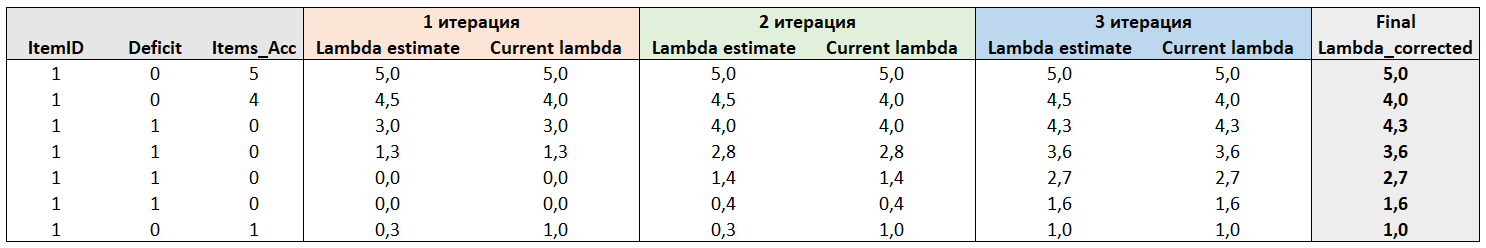

In [238]:
def add_lambda_corrected_grouped(df, window=30, iterations=3):
    """Векторизованная обработка по группам без предупреждений"""
    
    def process_group(group):
        """Обрабатывает одну группу (один товар)"""
        product_data = group.copy().sort_values('date')
        
        # Начальное приближение
        product_data['current_lambda'] = product_data['Items_Acc']
        
        for i in range(iterations):
            # Шаг 1: Скользящее среднее
            product_data['lambda_estimate'] = (
                product_data['current_lambda']
                .rolling(window=window, min_periods=10, center=False)
                .mean()
            )
            
            # Заполняем пропуски без inplace (исправляем предупреждения)
            product_data['lambda_estimate'] = product_data['lambda_estimate'].ffill()
            product_data['lambda_estimate'] = product_data['lambda_estimate'].bfill()
            
            # Шаг 2: Корректируем для дефицитных дней
            product_data['current_lambda'] = np.where(
                product_data['deficit'] == 1,
                np.maximum(product_data['lambda_estimate'], product_data['Items_Acc']),
                product_data['Items_Acc']
            )
        
        # Финальная коррекция
        product_data['lambda_corrected'] = np.where(
            product_data['deficit'] == 1,
            product_data['lambda_estimate'],
            product_data['Items_Acc']
        )
        
        return product_data
    
    # Применяем функцию к каждой группе
    result_df = df.groupby('RezonItemID').apply(process_group).reset_index(drop=True)
    
    return result_df

# Вызов функции
result_df = add_lambda_corrected_grouped(cleaned_df)

# Удаляем 211 пропущенных значений lambda_corrected
# Это новые товары, появившиеся только в сентябре, о них нет никакой информации
result_df = result_df[result_df['lambda_corrected'].notna()]

/tmp/ipykernel_98916/1548289887.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby('RezonItemID').apply(process_group).reset_index(drop=True)


In [262]:
# ----------------------------------------------------------------------
# ------------------------ СЭМПЛИРОВАНИЕ СПРОСА ------------------------
# ----------------------------------------------------------------------

def restore_demand_grouped(df):
    """Сэмплирование спроса из распределения Пуассона для всех товаров"""
    
    def process_demand_group(group):
        """Обрабатывает одну группу (один товар)"""
        product_data = group.copy()
        
        # Используем lambda_corrected
        lambda_value = product_data["lambda_corrected"].values
        sales_oracle_day = product_data["Items_Acc"].fillna(0).values
        max_sales = product_data["Items_Acc"].max()
        
        # Сэмплирование из Пуассона
        product_data["demand"] = np.fmin(
            np.full(len(lambda_value), max_sales),  # Ограничение сверху
            np.fmax(
                np.random.poisson(lambda_value, size=len(lambda_value)),
                sales_oracle_day  # Ограничение снизу - фактические продажи
            )
        )
        
        return product_data
    
    # Применяем функцию ко всем группам
    result_df = df.groupby('RezonItemID').apply(process_demand_group).reset_index(drop=True)
    
    return result_df

# Использование:
result_df = restore_demand_grouped(result_df)

/tmp/ipykernel_98916/24113190.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby('RezonItemID').apply(process_demand_group).reset_index(drop=True)


In [265]:
result_df['real_demand'] = np.where(
            result_df['deficit'] == 1,
            result_df['demand'],         # если есть дефицит -> спрос = посчитанный спрос по Пуассону
            result_df['Items_Acc']       # если нет дефицита -> спрос = фактические продажи
        )

result_df

,RezonItemID,date,stock_qty,Items_Acc,deficit,current_lambda,lambda_estimate,lambda_corrected,demand,real_demand
0,139962554,2024-08-29,1.0,0.0,0,0.0,0.372000,0.000000,0.0,0.0
1,139962554,2024-08-29,1.0,0.0,0,0.0,0.372000,0.000000,0.0,0.0
2,139962554,2024-08-30,1.0,0.0,0,0.0,0.372000,0.000000,0.0,0.0
3,139962554,2024-08-30,1.0,2.0,0,2.0,0.372000,2.000000,2.0,2.0
4,139962554,2024-08-31,1.0,1.0,0,1.0,0.372000,1.000000,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...
41667984,2915438756,2025-09-29,0.0,0.0,1,0.0,0.000000,0.000000,0.0,0.0
41667985,2915438756,2025-09-30,0.0,1.0,1,1.0,0.033333,0.033333,1.0,1.0
41667986,2916221138,2025-09-30,1.0,1.0,0,1.0,NaN,1.000000,1.0,1.0
41667987,2916843958,2025-09-30,52.0,0.0,0,0.0,NaN,0.000000,0.0,0.0


# TO BE DONE

- проверить на нескольких примерах корректность расчёта Пуассона от лямда
- проверить расчёт лямда
- сверить тоталы

# НИЖЕ ЧЕРНОВИК

In [261]:
def add_lambda_corrected_iterative(df, product_id, window=30, iterations=3):
    """Итеративно улучшаем оценку lambda с учётом дефицита"""
    
    product_mask = df["RezonItemID"] == product_id
    product_data = df[product_mask].copy().sort_values('date')
    
    # Начальное приближение: фактические продажи
    product_data['current_lambda'] = product_data['Items_Acc']
    
    for i in range(iterations):
        
        # Шаг 1: Скользящее среднее
        product_data['lambda_estimate'] = (
            product_data['current_lambda']
            .rolling(window=window, min_periods=10, center=False)
            .mean()
        )
        
        # Заполняем пропуски
        product_data['lambda_estimate'].fillna(method='ffill', inplace=True)
        product_data['lambda_estimate'].fillna(method='bfill', inplace=True)
        
        # Шаг 2: Корректируем для дефицитных дней
        # В дни дефицита спрос мог быть выше факта
        product_data['current_lambda'] = np.where(
            product_data['deficit'] == 1,
            np.maximum(product_data['lambda_estimate'], product_data['Items_Acc']),
            product_data['Items_Acc']  # для не-дефицита оставляем факт
        )
    
    # ФИНАЛЬНАЯ КОРРЕКЦИЯ: для не-дефицитных дней используем фактический спрос
    product_data['final_lambda'] = np.where(
        product_data['deficit'] == 1,
        product_data['lambda_estimate'],  # для дефицита - нашу оценку
        product_data['Items_Acc']         # для не-дефицита - фактический спрос
    )
    
    df.loc[product_mask, 'lambda_corrected'] = product_data['final_lambda']
    return df

In [ ]:
# ----------------------------------------------------------------------
# ------------------------ СЭМПЛИРОВАНИЕ СПРОСА ------------------------
# ----------------------------------------------------------------------


def restore_demand(df, sku_id, type='window'):
    """Сэмплирование спроса из распределения Пуассона

    Args:
        df:
            [pandas.DataFrame] Исходный DataFrame
        store_id:
            [int] ID магазина
        product_id:
            [int] ID товара
        type:
            [string - 'promo' or 'window'] Тип lambda для восстановления спроса

    Returns:
        df:
            [pandas.DataFrame] Исходный DataFrame + demand
    """

    max_sales = df[
        (df["RezonItemID"] == product_id)].s_qty.max()

    sales_oracle_day = df[
        (df["RezonItemID"] == product_id)]["s_qty"]

    lambda_value = df[
            (df["RezonItemID"] == product_id)]["lambda_window"].values

    lambda_value = lambda_value.astype(np.float64)
    sales_oracle_day = sales_oracle_day.fillna(0)
    sales_oracle_day = sales_oracle_day.values

    df.loc[
        (df["RezonItemID"] == product_id),
        "demand"
    ] = np.fmin(
        np.full((1, len(lambda_value)), max_sales),
        np.fmax(
            np.random.poisson(lambda_value, size=len(lambda_value)),
            sales_oracle_day
        ).astype(np.float64),
    ).tolist()[0]

    return df

In [ ]:
def add_lambda_corrected_iterative(df, product_id, window=30, iterations=3):
    """Итеративно улучшаем оценку lambda с учётом дефицита"""
    
    product_mask = df["RezonItemID"] == product_id
    product_data = df[product_mask].copy().sort_values('date')
    
    # Начальное приближение: фактические продажи
    product_data['current_lambda'] = product_data['Items_Acc']
    
    for i in range(iterations):
        
        # Шаг 1: Скользящее среднее
        product_data['lambda_estimate'] = (
            product_data['current_lambda']
            .rolling(window=window, min_periods=10, center=False)
            .mean()
        )
        
        # Заполняем пропуски
        product_data['lambda_estimate'].fillna(method='ffill', inplace=True)
        product_data['lambda_estimate'].fillna(method='bfill', inplace=True)
        
        # Шаг 2: Корректируем для дефицитных дней
        # В дни дефицита спрос мог быть выше факта
        product_data['current_lambda'] = np.where(
            product_data['deficit'] == 1,
            np.maximum(product_data['lambda_estimate'], product_data['Items_Acc']),
            product_data['Items_Acc']  # для не-дефицита оставляем факт
        )
    
    df.loc[product_mask, 'lambda_corrected'] = product_data['lambda_estimate']
    return df